# How to run CorrHOD_cubic

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from pycorr import project_to_multipoles

from CorrHOD import CorrHOD_cubic

# Get the number of threads available
import multiprocessing
nthread = multiprocessing.cpu_count()
print(f'Number of threads available: {nthread}')

Number of threads available: 256


In [3]:
# Logging
import sys
from CorrHOD import create_logger
from mockfactory import setup_logging

# Get a logger object
setup_logging() # Initialize the logging for all the loggers that will not have a handler 
logger = create_logger('CorrHOD', level='debug', stream=sys.stdout)

In [4]:
# Define the parameters we will use
path2config = Path('config.yaml')

# let's define some parameters to pass to the HOD model
HOD_params = {
    'logM_cut': 12,
    'logM1':    13, 
    'sigma':    0.32, 
    'alpha':    1.11, 
    'kappa':    10**(-1.43), 
    'alpha_c':  0.0, 
    'alpha_s':  0.0, 
    'Bcent':    0.0, 
    'Bsat':     0.0
}
# The parameters we did not define will take the default values from the config file

# DensitySplit parameters
nquantiles = 10 # Number of quantiles to split the sample

# Correlation functions parameters
sbins = np.linspace(0.1, 30, 50) # Bins in s for the CFs (default ones)
edges = [sbins, np.linspace(-1, 1, 60)]

In [ ]:
# Initialize the CorrHOD object
Object = CorrHOD_cubic(path2config, HOD_params, los='z')
Object.initialize_halo() # Load the halo catalog
Object.populate_halos() # Populate the halos with galaxies

print('Tracer used: ', Object.tracer)

In [ ]:
data_positions = Object.get_tracer_positions() # Get the positions of the galaxies

[000600.30] [0/1] 07-12 13:41  FFTWEngine                INFO     Saving wisdom to wisdom.shape-400-400-400.type-float64.nthreads-256.npy.


Text(0, 0.5, 'PDF')

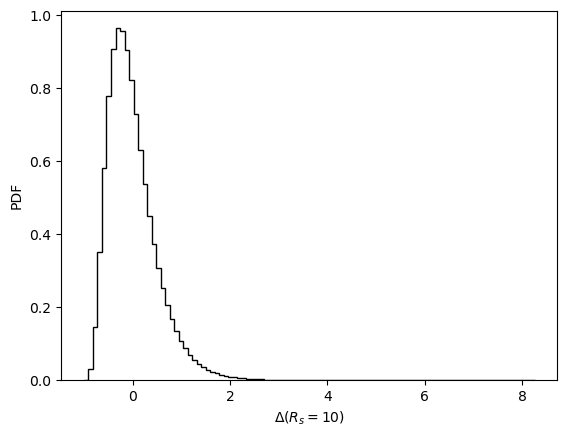

In [ ]:
# Compute the DensitySplit
quantiles, density = Object.compute_DensitySplit(nquantiles=nquantiles, nthread=nthread)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Plot the quantiles density
from pandas import qcut
density_quantiles = []
q_cut = qcut(density, nquantiles, labels=False) 

for i in range(nquantiles):
    density_quantiles.append(density[q_cut == i])
    ax[1].hist(density_quantiles[i], bins=100, density=True, alpha=0.8, label=f'Q{i}')

ax[0].hist(density, bins=500, density=True, alpha=0.7, color='k')

ax[0].set_xlabel(r'$\Delta(R_s)$', fontsize=15)
ax[1].set_xlabel(r'$\Delta(R_s)$', fontsize=15)
ax[0].set_ylabel('PDF', fontsize=15)
fig.suptitle(f'Density PDFs for {nquantiles} quantiles', fontsize=15);

In [ ]:
# Plot the positions in the sky
fig, ax = plt.subplots(1, 2, figsize=(10, 20))

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
boxsize = 2000

cut = data_positions[:, 2] < 50
ax[0].scatter(data_positions[cut, 0], data_positions[cut, 1], s=0.1, color='grey', label='Galaxies')
ax[1].scatter(data_positions[cut, 0], data_positions[cut, 1], s=0.1, color='grey', label='Galaxies')

for i, ids in enumerate([0, nquantiles-1]):
    cut = quantiles[ids][:, 2] < 50

    ax[i].scatter(quantiles[ids][cut, 0], quantiles[ids][cut, 1], s=0.1, color='crimson', label='Density split')
    ax[i].set_title(f'DS{ids}', fontsize=12)

    ax[i].set_xlabel('x [Mpc/h]', fontsize=12)
    ax[i].set_ylabel('x [Mpc/h]', fontsize=12)
#     ax[i].set_xlim(0, boxsize)
#     ax[i].set_ylim(0, boxsize)

ax[0].legend(fontsize=12, markerscale=5, loc='upper left')
plt.show();

In [ ]:
# Downsample galaxies and quantiles
new_n = 5e-4 # New number density
Object.downsample_data(new_n=new_n);

In [ ]:
# Compute the 2PCF
xi_HOD = Object.compute_2pcf(edges=edges, nthread=nthread)

In [ ]:
# Compute the Cross-Correlation for DS0 and DS9
xi_HOD_0 = Object.compute_cross_corr(0, edges=edges, nthread=nthread)
xi_HOD_9 = Object.compute_cross_corr(9, edges=edges, nthread=nthread)

### The `run_all()` method

The following code will run the full analysis for the cubic HOD model.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from CorrHOD import CorrHOD_cubic

# Get the number of threads available
import multiprocessing
nthread = multiprocessing.cpu_count()
print(f'Number of threads available: {nthread}')

# Get the loggers
from CorrHOD import create_logger
from mockfactory import setup_logging

setup_logging() # Initialize the logging for all the loggers that will not have a handler 
logger = create_logger('CorrHOD', level='debug', stream=sys.stdout)

path2config = Path('config.yaml')

HOD_params = {
    'logM_cut': 12,
    'logM1':    13, 
    'sigma':    0.32, 
    'alpha':    1.11, 
    'kappa':    10**(-1.43), 
    'alpha_c':  0.0, 
    'alpha_s':  0.0, 
    'Bcent':    0.0, 
    'Bsat':     0.0
}

# DensitySplit parameters
nquantiles = 10 # Number of quantiles to split the sample

Object = CorrHOD_cubic(path2config, HOD_params)

# We artificially reduce the number density to speed up the computation time
new_n = 1e-4 # Density to downsample to after the DensitySplit

Object.run_all(downsample_to=new_n, nquantiles=nquantiles, nthread=nthread)

In [ ]:
# Plot the CFs

fig, ax = plt.subplots(2, 3, sharex=True, figsize=(16, 7))

colors = [f'C{i}' for i in range(nquantiles)]

s = Object.CF['average']['s'] # Get the separation s (identical for all CFs)

for i in range(nquantiles):
    
    color = colors[i]
    alpha = 0.6
    
    # Plot the multipoles of the auto correlation
    poles1 = Object.CF['average']['Auto'][f'DS{i}']
    ax[0,0].plot(s, poles1[0]*s**2, alpha=alpha, color=color, label = f'DS{i}')
    ax[0,1].plot(s, poles1[1]*s**2, alpha=alpha, color=color)
    ax[0,2].plot(s, poles1[2]*s**2, alpha=alpha, color=color)

    # Plot the multipoles of the cross correlation
    poles2 = Object.CF['average']['Cross'][f'DS{i}']
    ax[1,0].plot(s, poles2[0]*s**2, alpha=alpha, color=color)
    ax[1,1].plot(s, poles2[1]*s**2, alpha=alpha, color=color)
    ax[1,2].plot(s, poles2[2]*s**2, alpha=alpha, color=color)
    
#Add the 2PCF on both plots

poles = Object.CF['average']['2PCF']
for i in [0, 1]:
    ax[i,0].plot(s, poles[0]*s**2, alpha=alpha, color='k', ls='--', label='2PCF')
    ax[i,1].plot(s, poles[1]*s**2, alpha=alpha, color='k', ls='--')
    ax[i,2].plot(s, poles[2]*s**2, alpha=alpha, color='k', ls='--')


ax[0,0].legend()
ax[1,0].set_xlabel(r'$s$')
ax[1,0].set_ylabel(r'$s^2\xi_l(s)$')
ax[0,0].set_ylabel(r'$s^2\xi_l(s)$')
ax[0,0].set_title('Monopole', fontsize=11)
ax[0,1].set_title('Quadrupole', fontsize=11)
ax[0,2].set_title('Hexadecapole', fontsize=11)
fig.suptitle('Auto (top) and Cross (bottom) Correlation for c000', fontsize=15, y=1);

In [ ]:
# Access the times

# The times are stored in a dictionary
times_dict = Object.times_dict

# Let's compute some interesting times to look at

total_time = times_dict['run_all']

mean_los_time = np.mean([times_dict[los]['run_los'] for los in ['x', 'y', 'z']], axis=0)
mean_2PCF_time = np.mean([times_dict[los]['compute_2pcf'] for los in ['x', 'y', 'z']], axis=0)
mean_auto_time = np.mean([times_dict[los]['compute_auto_corr'][f'DS{i}'] for los in ['x', 'y', 'z'] for i in range(nquantiles)], axis=0)
mean_cross_time = np.mean([times_dict[los]['compute_cross_corr'][f'DS{i}'] for los in ['x', 'y', 'z'] for i in range(nquantiles)], axis=0)
total_auto_time = np.mean([np.sum([times_dict[los]['compute_auto_corr'][f'DS{i}'] for i in range(nquantiles)], axis=0) for los in ['x', 'y', 'z']], axis=0)
total_cross_time = np.mean([np.sum([times_dict[los]['compute_cross_corr'][f'DS{i}'] for i in range(nquantiles)], axis=0) for los in ['x', 'y', 'z']], axis=0)

#Display the times
print(f'Total time: {total_time:.2f} s')
print(f'Mean time for computing a LOS: {mean_los_time:.2f} s')
print(f'Mean time for computing the 2PCF: {mean_2PCF_time:.2f} s')
print(f'Mean time for computing an auto correlation: {mean_auto_time:.2f} s')
print(f'Mean time for computing a cross correlation: {mean_cross_time:.2f} s')
print(f'Mean time for computing all auto correlations: {total_auto_time:.2f} s')
print(f'Mean time for computing all cross correlations: {total_cross_time:.2f} s')

### Load a catalog in the class

It is also possible to run the analysis on a catalog that is not generated by the class. The catalog must be a `pandas` array.

In [ ]:
# Import the data
import pandas as pd
from CorrHOD.catalogs import read_fits

path = '/global/cfs/cdirs/desi/cosmosim/FirstGenMocks/AbacusSummit/CubicBox/BGS_v2/z0.200/AbacusSummit_base_c000_ph000/BGS_box_ph000.fits'
data_cubic = read_fits(path, check_cubic_format=True, print_column_names=True)

# Apply some cuts to the data
mask = (data_cubic['R_MAG_ABS'] < -21.5).to_numpy() # Create a mask to select the galaxies that are brighter than the magnitude cut
data_cubic = pd.DataFrame(data_cubic.values[mask], columns=data_cubic.columns) # Apply the mask to the data

In [ ]:
# Create a CorrHOD object to make computation easier
path2config = Path('config.yaml') # Useless here, but we need it to create the object
Object = CorrHOD_cubic(path2config) 
Object.cubic_dict = data_cubic

In [ ]:
# And then , run the analysis as usual
Object.get_tracer_positions(); # Get the positions of the tracers and get the coordinates in the right shift

...